# Testing Transformer performance on CIFAR10 challenge according to different channel size
Trying to make the Encoder_MultiheadedAttention.py work for the CIFAR 10 challenge. 


In [7]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
import math

#from Encoder_MultiheadedAttention import Encoder

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

cuda


Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5..1.4921569].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5..1.4921569].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5..1.4529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5..1.2098039].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5..1.3352941].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5..1.2411765].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5..1.5].
Clipping input data to the valid 

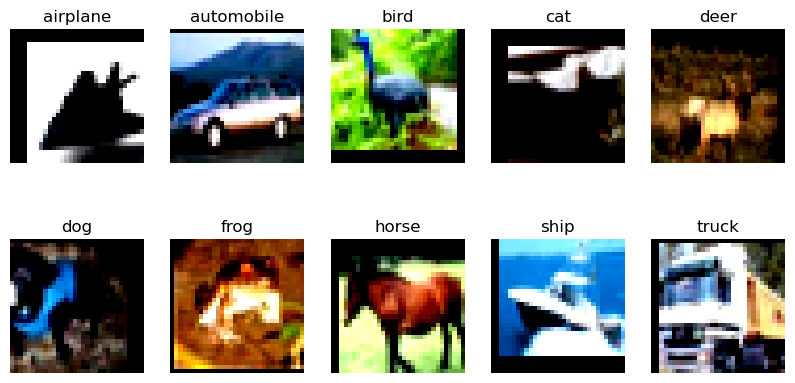

In [8]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25)),
                                      ])
transform_test = transforms.Compose([transforms.ToTensor(), 
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25)),])

batch_size = 128

# Download and load the data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Create imbalanced traindataset
num_samples_per_class = {k:(k+1)*500 for k in range(10)}
class_to_indices = {cls: np.where(np.array(trainset.targets) == cls)[0] for cls in range(10)}
imbalanced_indices = []
for cls, count in num_samples_per_class.items():
    indices = class_to_indices[cls][:count]  # Select the first `count` samples
    imbalanced_indices.extend(indices)
imbalanced_trainset = Subset(trainset, imbalanced_indices)

trainloader = torch.utils.data.DataLoader(imbalanced_trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
          "horse", "ship", "truck"]

# get one image from each class
images = []
for i in range(10):
    for image, label in trainset:
        if label == i:
            images.append(image)
            break

# plot the images
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i in range(10):
    ax = axs[i//5, i%5]
    ax.imshow(images[i].permute(1, 2, 0).numpy() / 2 + 0.5)
    ax.set_title(classes[i])
    ax.axis('off')
plt.show()

In [9]:
def validate(model, testloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            #print("Output: ", outputs[12])
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            #print("Total: ", total)
            correct += (predicted == labels).sum().item()
    return correct / total

def train(model, trainloader, testloader, criterion, optimizer, num_epochs=10, device='cpu'):
    model.to(device)
    acc_init = validate(model, testloader, device)
    print(f"Accuracy before Training: {acc_init}")
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for data in tqdm(trainloader): 
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            preds = model(inputs)
            
            
            loss = criterion(preds, labels)
            loss.backward()

            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch {epoch+1}, loss: {running_loss/len(trainloader)}")
        train_accuracy = validate(model, trainloader, device)
        print(f"Accuracy on train set: {train_accuracy}")
        accuracy = validate(model, testloader, device)
        print(f"Accuracy on test set: {accuracy}")

In [ ]:
"""transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.25,)),
    FlattenTransform()
])

transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.25,)),
    FlattenTransform()
])

# Update the datasets with the new transformations
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Update the dataloaders with the new datasets
trainloader = torch.utils.data.DataLoader(imbalanced_trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)"""

In [10]:
class Attention(nn.Module): 
    def __init__(self, dim_1, dim_2): 
        super(Attention, self).__init__()
        self.K = nn.Linear(dim_1, dim_2, bias=False)
        self.Q = nn.Linear(dim_1, dim_2, bias=False)
        self.V = nn.Linear(dim_1, dim_2, bias=False)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x): 
        #print("X: ", x.size())
        scores = self.K(x) @ self.Q(x).transpose(-2, -1)
        #print("scores: ", scores.size())
        att_weight = self.softmax(scores / np.sqrt(x.shape[-1]))
        #print("att_weight", att_weight.size())
        out = att_weight @ self.V(x)
        #print("out weight: ", out.size())
        return out

class MultiHeadAttention(nn.Module): 
    def __init__(self, dim_1, dim_2, num_heads): 
        super(MultiHeadAttention, self).__init__()
        self.heads = nn.ModuleList(Attention(dim_1, dim_2) for _ in range(num_heads))
        self.Z = nn.Linear(num_heads * dim_1, dim_1)

    def forward(self, x): 
        #print(x.size())
        out = torch.cat([head(x) for head in self.heads], dim=-1)
        #print(out.size())
        return self.Z(out)
    
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        #self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x
    
class EncoderLayer(nn.Module):
    def __init__(self, dim_1, head_size, num_heads, ff_size): 
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(dim_1, head_size, num_heads)
        self.layer_norm = nn.LayerNorm(dim_1)
        self.ff = nn.Sequential(
            nn.Linear(dim_1, ff_size), 
            nn.GELU(), 
            nn.Linear(ff_size, dim_1)
        )  
    
    def forward(self, x): 
        out = x + self.mha(x)
        out = self.layer_norm(out)
        temp = out
        out = temp + self.ff(out)
        out = self.layer_norm(out)
        return out

class Encoder(nn.Module): 
    def __init__(self, dim, head_size, num_heads, ff_size, num_encoders, num_classes): 
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList(EncoderLayer(dim_1=dim, head_size=head_size, num_heads=num_heads, ff_size=ff_size) for _ in range(num_encoders))
        #self.pe = PositionalEncoding(dim, max_len=128)
        self.linear = nn.Linear(dim, num_classes)
    
    def forward(self, x): 
        #x = x + self.pe(x)
        for layer in self.layers: 
            x = layer(x)
        #print("X size: ", x.size())
        x = x.mean(dim=1) 
        x = x.mean(dim=1)
        out = self.linear(x)
        #print("Out size: ", out.size())
        return self.linear(x)


In [11]:
# Get one image from the dataset
image, label = trainset[0]

dim_1 = image.size(dim=1)
dim_2 = image.size(dim=2)
K = nn.Linear(dim_1, dim_2, bias=False)
Q = nn.Linear(dim_1, dim_2, bias=False)
V = nn.Linear(dim_1, dim_2, bias=False)
softmax = nn.Softmax(dim=-1)

scores = K(image) @ Q(image)
att_weight = softmax(scores / np.sqrt(image.shape[-1]))
out = att_weight @ V(image)
out.size()

torch.Size([3, 32, 32])

In [ ]:
# Flatten the image tensor and calculate the dimensions for the Encoder
image_dim = 3072  # 3 * 32 * 32 = 3072
dim = image_dim  # Input dimension for the Encoder
head_size = 8  # Example head size
num_heads = 4  # Example number of heads

# Add a flattening step to the transformations
"""ArithmeticError
class FlattenTransform:
    def __call__(self, tensor):
        return tensor.view(-1)

transform_train.transforms.append(FlattenTransform())
transform_test.transforms.append(FlattenTransform())"""

# Initialize the Encoder model with the calculated dimensions
model = Encoder(dim=32, head_size=32, num_heads=num_heads, ff_size=512, num_encoders=2, num_classes=10)

criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model.parameters(), lr=0.0001)
train(model, trainloader, testloader, criterion, optimizer, num_epochs=40, device=device)

Accuracy before Training: 0.0948


100%|██████████| 215/215 [00:04<00:00, 50.05it/s]

Epoch 1, loss: 2.117700181450955


Accuracy on train set: 0.27785454545454547
Accuracy on test set: 0.1592


100%|██████████| 215/215 [00:04<00:00, 50.80it/s]

Epoch 2, loss: 1.991425356199575


Accuracy on train set: 0.30916363636363636
Accuracy on test set: 0.1713


100%|██████████| 215/215 [00:04<00:00, 50.90it/s]

Epoch 3, loss: 1.9277033667231716


Accuracy on train set: 0.32705454545454543
Accuracy on test set: 0.1703


100%|██████████| 215/215 [00:04<00:00, 49.79it/s]

Epoch 4, loss: 1.8878687082335006


Accuracy on train set: 0.33574545454545457
Accuracy on test set: 0.1812


100%|██████████| 215/215 [00:04<00:00, 49.62it/s]

Epoch 5, loss: 1.8517402798630471


Accuracy on train set: 0.3532727272727273
Accuracy on test set: 0.1864


100%|██████████| 215/215 [00:04<00:00, 47.75it/s]

Epoch 6, loss: 1.8251672955446465


Accuracy on train set: 0.3641090909090909
Accuracy on test set: 0.2044


100%|██████████| 215/215 [00:04<00:00, 51.94it/s]

Epoch 7, loss: 1.798208722402883


Accuracy on train set: 0.3749818181818182
Accuracy on test set: 0.2122


100%|██████████| 215/215 [00:04<00:00, 49.92it/s]

Epoch 8, loss: 1.775650300536045


Accuracy on train set: 0.38796363636363634
Accuracy on test set: 0.2268


100%|██████████| 215/215 [00:04<00:00, 50.37it/s]

Epoch 9, loss: 1.759275646542394


Accuracy on train set: 0.39447272727272725
Accuracy on test set: 0.2315


100%|██████████| 215/215 [00:04<00:00, 48.14it/s]

Epoch 10, loss: 1.7415160118147384


Accuracy on train set: 0.3972727272727273
Accuracy on test set: 0.2441


100%|██████████| 215/215 [00:04<00:00, 49.85it/s]

Epoch 11, loss: 1.730799239180809


Accuracy on train set: 0.3978909090909091
Accuracy on test set: 0.2496


100%|██████████| 215/215 [00:04<00:00, 49.72it/s]

Epoch 12, loss: 1.7182473759318506


Accuracy on train set: 0.4057818181818182
Accuracy on test set: 0.25


100%|██████████| 215/215 [00:04<00:00, 51.44it/s]

Epoch 13, loss: 1.7076644442802251


Accuracy on train set: 0.4093090909090909
Accuracy on test set: 0.2579


100%|██████████| 215/215 [00:04<00:00, 51.43it/s]

Epoch 14, loss: 1.6949695698050566


Accuracy on train set: 0.41709090909090907
Accuracy on test set: 0.2568


100%|██████████| 215/215 [00:04<00:00, 50.20it/s]

Epoch 15, loss: 1.6848241867021072


Accuracy on train set: 0.4164
Accuracy on test set: 0.2613


100%|██████████| 215/215 [00:04<00:00, 50.84it/s]

Epoch 16, loss: 1.6776906113291896


Accuracy on train set: 0.4141090909090909
Accuracy on test set: 0.2601


100%|██████████| 215/215 [00:04<00:00, 51.38it/s]

Epoch 17, loss: 1.6715696850488353


Accuracy on train set: 0.4274181818181818
Accuracy on test set: 0.2711


100%|██████████| 215/215 [00:04<00:00, 50.59it/s]

Epoch 18, loss: 1.6615128506061643


Accuracy on train set: 0.4289454545454545
Accuracy on test set: 0.2762


100%|██████████| 215/215 [00:04<00:00, 51.14it/s]

Epoch 19, loss: 1.653759803328403


Accuracy on train set: 0.42970909090909093
Accuracy on test set: 0.2792


100%|██████████| 215/215 [00:04<00:00, 50.02it/s]

Epoch 20, loss: 1.6451082007829534


Accuracy on train set: 0.43618181818181817
Accuracy on test set: 0.2798


100%|██████████| 215/215 [00:04<00:00, 51.37it/s]

Epoch 21, loss: 1.6416110565496045


Accuracy on train set: 0.4395272727272727
Accuracy on test set: 0.2819


100%|██████████| 215/215 [00:04<00:00, 50.70it/s]

Epoch 22, loss: 1.6346021657766299


Accuracy on train set: 0.4400363636363636
Accuracy on test set: 0.288


100%|██████████| 215/215 [00:04<00:00, 50.37it/s]

Epoch 23, loss: 1.6295630460561707


Accuracy on train set: 0.4395272727272727
Accuracy on test set: 0.2852


100%|██████████| 215/215 [00:04<00:00, 50.67it/s]

Epoch 24, loss: 1.6208433422931405


Accuracy on train set: 0.4435636363636364
Accuracy on test set: 0.2904


100%|██████████| 215/215 [00:04<00:00, 51.65it/s]

Epoch 25, loss: 1.6144922966180846
